In [1]:
import sys
import os
# insert at 1, 0 is the script path (or '' in REPL)
base_dir = '/'.join(os.getcwd().split('/')[:-1])
sys.path.insert(0, base_dir)

from parameter_estimation.reproduction_number import ReproductionNumber
import pandas as pd
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from copy import deepcopy


%load_ext rpy2.ipython

/home/giulianonetto/.virtualenvs/COVID-19/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/giulianonetto/.virtualenvs/COVID-19/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [2]:
t_max = 5
window_width = 6
N = 100_000

In [3]:
def run_Rt_estimation(incidence, prior_shape, prior_scale, mean_si, sd_si, t_max, window_width):
    
    si_pars = {'mean': mean_si, 'sd': sd_si}
    
    Rt = ReproductionNumber(incidence=incidence,
                            si_pars=si_pars,
                            prior_shape=prior_shape, 
                            prior_scale=prior_scale,
                            window_width=window_width
                           )
    
    Rt.compute_posterior_parameters()

    Rt_posterior_sample = Rt.sample_from_posterior(sample_size=N)
    Rt.compute_posterior_summaries(posterior_sample=Rt_posterior_sample, t_max=t_max)

    results = Rt
    
    return results

### Prior predictive check (sort of)

#### Rt prior

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



    2.5%      25%      75%    97.5% 
1.072175 2.226266 4.113289 6.708464 
mean = 3.28802101053865, sd = 1.45708982335671
shape = 5.11695600475624, scale = 0.641006097560976


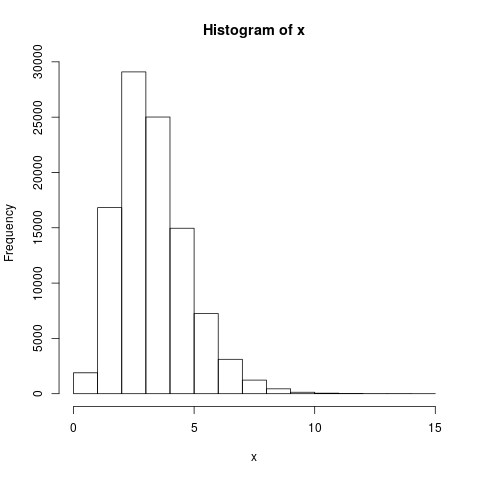

In [4]:
%%R

library(tidyverse)

f <- function(shape=NULL, scale=NULL, mu=NULL, sd=NULL) {
    if (!is.null(mu)) {
        shape = (mu/sd)^2
        scale = (sd^2)/mu
    }
    x <- rgamma(1e5, shape = shape, scale = scale)
    print(quantile(x, prob = c(.025, .25, .75, .975)))
    print(str_glue("mean = {mean(x)}, sd = {sd(x)}"))
    print(str_glue("shape = {shape}, scale = {scale}"))
    hist(x)
}

f(mu=3.28, sd=1.45)

#### SI distribution

     2.5%       25%       75%     97.5% 
 2.366649  5.013777  9.407202 15.529023 
mean = 7.49137009278362, sd = 3.40908695051015
shape = 4.8659169550173, scale = 1.54133333333333


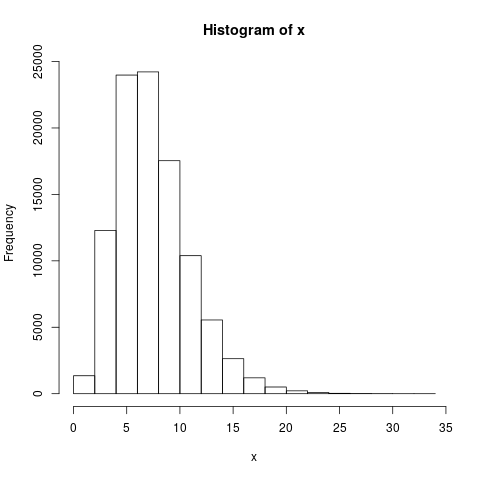

In [5]:
%%R

f(mu = 7.5, sd = 3.4)

# Results

## Brazil - get data

In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv')
data['date'] = data['date'].astype('datetime64[ns]')

def get_incidence_data(data, region):
    incidence = data[data['state'] == region][['date', 'newCases', 'totalCases']]
    incidence = incidence.set_index('date')
    
    incidence = (incidence.asfreq('d')
                 .assign(newCases=lambda x: x.newCases.fillna(0),
                         totalCases=lambda x: x.totalCases.fillna(method='ffill'))
                 .query('totalCases >= 50'))
    incidence = incidence.reset_index()
    incidence.columns = ['dates', 'incidence', 'totalCases']
    incidence = incidence.set_index('dates')
    
    return incidence[['incidence']]


brazil_incidence = get_incidence_data(data=data, region="TOTAL")

### Brazil - estimate

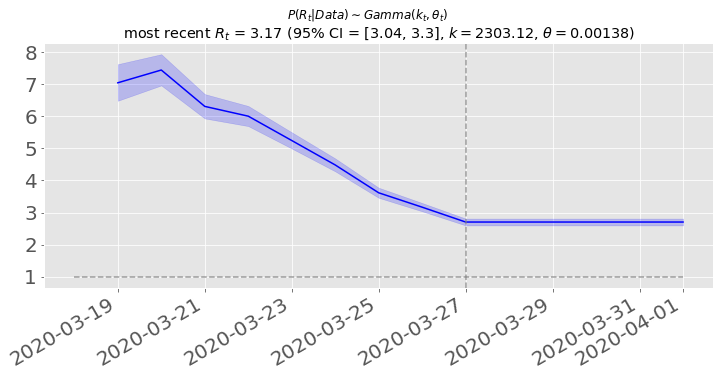

In [7]:


brazil_results = run_Rt_estimation(incidence=brazil_incidence,
                                   prior_shape=5.12, prior_scale=0.64,
                                   mean_si=7.5, sd_si=3.4,
                                   t_max=t_max, window_width=window_width)

last_known_day = brazil_results.posterior_summary.query('end_dates == "2020-03-26"')

most_recent_Rt = last_known_day['Rt_mean'].round(2).values[0]
upper = last_known_day['Rt_q0.975'].round(2).values[0]
lower = last_known_day['Rt_q0.025'].round(2).values[0]
brazil_posterior_shape = last_known_day['Rt_shape'].values[0]
brazil_posterior_scale = last_known_day['Rt_scale'].values[0]
title = f"most recent $R_t$ = {most_recent_Rt} (95% CI = [{lower}, {upper}], $k = {round(brazil_posterior_shape, 2)}$, $\\theta = {round(brazil_posterior_scale, 5)}$)"

brazil_results.plot_reproduction_number(title=title)

## Check whether R package agrees

implied R0 5.44388609178241

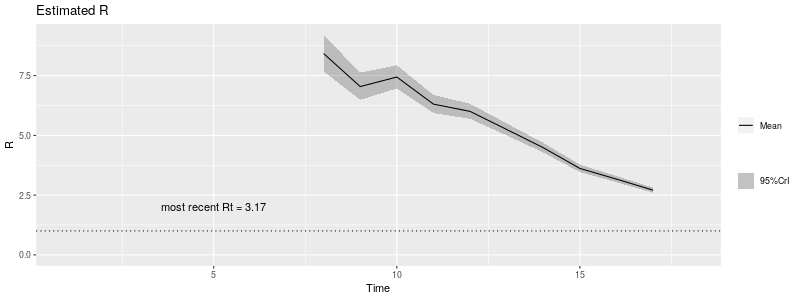

In [8]:
%%R -i brazil_incidence -h 300 -w 800

library(EpiEstim)
library(patchwork)
library(tidyverse)

df <- data.frame(incidence = brazil_incidence)

window_size <- 6
t_start = seq(2, nrow(df) - window_size, 1)
res <- estimate_R(
    df, 
    method="parametric_si",
    config = make_config(list(mean_si = 7.5, std_si = 3.4,
                              mean_prior = 3.3, std_prior=1.45,
                              t_start = t_start, t_end = t_start + window_size ))
)


p2 <- plot(res, what = "R")
p2 <- p2 +  geom_text(
         data = . %>% filter(end == 16),
         aes(label = paste0("most recent Rt = ", round(meanR, 2)),
             x = 5, y = 2)
         )

cat(paste0("implied R0 ",mean(res$R[, 3])))

p2

## Run for each state

In [9]:
def plot_results(results, region, filename):
    d = results.posterior_summary
    last_fitted_day = max(d[d['estimation_type'] == "fitted"]["end_dates"])
    last_fitted_day = d.query(f'end_dates == "{last_fitted_day}"')
    n = results.incidence.shape[0]

    most_recent_Rt = last_fitted_day['Rt_mean'].round(2).values[0]
    upper = last_fitted_day['Rt_q0.975'].round(2).values[0]
    lower = last_fitted_day['Rt_q0.025'].round(2).values[0]
    posterior_shape = last_fitted_day['Rt_shape'].values[0]
    posterior_scale = last_fitted_day['Rt_scale'].values[0]
    title = f"{region}: most recent $R_t$ = {most_recent_Rt} (95% CI = [{lower}, {upper}], n = {n}, $k = {round(posterior_shape, 2)}$, $\\theta = {round(posterior_scale, 5)}$)"

    results.plot_reproduction_number(title=title, filename=filename)


In [10]:
states = list(set([i for i in data['state'] if i != "TOTAL"]))

state_results = {}
for state in states:
    incidence = get_incidence_data(data=data, region=state)
    n = incidence.shape[0]
    if n > 7:
        results = run_Rt_estimation(incidence=incidence,
                                    prior_shape=brazil_posterior_shape, # uses most recent Rt dist from Brazil posterior
                                    prior_scale=brazil_posterior_scale,
                                    mean_si=7.5, sd_si=3.4,
                                    t_max=t_max, window_width=window_width)
        results.posterior_summary['source'] = 'own data'
    else:
        # when too few data points, use brazils results
        results = deepcopy(brazil_results)
        results.posterior_summary['source'] = 'Brazil data'
    plot_results(results=results,
                 region=state,
                 filename=f'/home/giulianonetto/Desktop/covid_plots/{state}.png')
    results.posterior_summary['state'] = state
    results.posterior_summary['R0'] = (results.posterior_summary
                                       .query('estimation_type == "fitted"')['Rt_mean'].mean())
    results.posterior_summary['R0_sd'] = (results.posterior_summary
                                          .query('estimation_type == "fitted"')['Rt_sd'].std())
    results.posterior_summary['n'] = n

    state_results[state] = results


In [11]:
states_summary = pd.concat([v.posterior_summary for _, v in state_results.items()], ignore_index=True)
states_summary

,start_dates,end_dates,Rt_mean,Rt_sd,Rt_q0.975,Rt_q0.025,Rt_shape,Rt_scale,estimation_type,source,state,R0,R0_sd,n
0,2020-03-21,2020-03-27,3.235586,0.065649,3.365489,3.108358,2440.12,0.001326,fitted,own data,RS,3.235586,NaN,8
1,NaT,2020-03-28,3.235586,0.065649,3.365489,3.108358,2440.12,0.001326,forecasted,own data,RS,3.235586,NaN,8
2,NaT,2020-03-29,3.235586,0.065649,3.365489,3.108358,2440.12,0.001326,forecasted,own data,RS,3.235586,NaN,8
3,NaT,2020-03-30,3.235586,0.065649,3.365489,3.108358,2440.12,0.001326,forecasted,own data,RS,3.235586,NaN,8
4,NaT,2020-03-31,3.235586,0.065649,3.365489,3.108358,2440.12,0.001326,forecasted,own data,RS,3.235586,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,NaT,2020-03-28,2.705350,0.054572,2.813488,2.599982,2467.12,0.001097,forecasted,Brazil data,PB,5.112596,0.082743,0
367,NaT,2020-03-29,2.705350,0.054572,2.813488,2.599982,2467.12,0.001097,forecasted,Brazil data,PB,5.112596,0.082743,0
368,NaT,2020-03-30,2.705350,0.054572,2.813488,2.599982,2467.12,0.001097,forecasted,Brazil data,PB,5.112596,0.082743,0
369,NaT,2020-03-31,2.705350,0.054572,2.813488,2.599982,2467.12,0.001097,forecasted,Brazil data,PB,5.112596,0.082743,0


In [12]:
import numpy as np
brazil_summary = brazil_results.posterior_summary
brazil_summary['state'] = 'Brazil'  # well....query('estimation_type == "fitted"')['Rt_mean'].mean()
brazil_summary['R0'] = brazil_summary.query('estimation_type == "fitted"')['Rt_mean'].mean()
brazil_summary['R0_sd'] = brazil_summary.query('estimation_type == "fitted"')['Rt_mean'].std()
brazil_summary['n'] = brazil_results.incidence.shape[0]
brazil_summary

,start_dates,end_dates,Rt_mean,Rt_sd,Rt_q0.975,Rt_q0.025,Rt_shape,Rt_scale,estimation_type,state,R0,R0_sd,n
0,2020-03-12,2020-03-18,NaN,NaN,NaN,NaN,NaN,NaN,fitted,Brazil,5.112596,1.71751,17
1,2020-03-13,2020-03-19,7.043168,0.290002,7.623104,6.482632,590.12,0.011934,fitted,Brazil,5.112596,1.71751,17
2,2020-03-14,2020-03-20,7.440872,0.247819,7.932622,6.960812,897.12,0.008294,fitted,Brazil,5.112596,1.71751,17
3,2020-03-15,2020-03-21,6.307868,0.193447,6.690907,5.932810,1063.12,0.005933,fitted,Brazil,5.112596,1.71751,17
4,2020-03-16,2020-03-22,6.003262,0.160330,6.320993,5.693894,1394.12,0.004306,fitted,Brazil,5.112596,1.71751,17
5,2020-03-17,2020-03-23,5.245036,0.128776,5.501255,4.996072,1663.12,0.003154,fitted,Brazil,5.112596,1.71751,17
6,2020-03-18,2020-03-24,4.483728,0.102665,4.687230,4.284605,1912.12,0.002345,fitted,Brazil,5.112596,1.71751,17
7,2020-03-19,2020-03-25,3.615997,0.080227,3.774657,3.460364,2037.12,0.001775,fitted,Brazil,5.112596,1.71751,17
8,2020-03-20,2020-03-26,3.168082,0.066231,3.298496,3.039803,2303.12,0.001375,fitted,Brazil,5.112596,1.71751,17
9,2020-03-21,2020-03-27,2.705350,0.054572,2.813488,2.599982,2467.12,0.001097,fitted,Brazil,5.112596,1.71751,17


In [13]:
final_summary = pd.concat([states_summary, brazil_summary], ignore_index=True)
final_summary = final_summary[final_summary.notna()["Rt_mean"]].reset_index()
final_summary

,index,start_dates,end_dates,Rt_mean,Rt_sd,Rt_q0.975,Rt_q0.025,Rt_shape,Rt_scale,estimation_type,source,state,R0,R0_sd,n
0,0,2020-03-21,2020-03-27,3.235586,0.065649,3.365489,3.108358,2440.12,0.001326,fitted,own data,RS,3.235586,NaN,8
1,1,NaT,2020-03-28,3.235586,0.065649,3.365489,3.108358,2440.12,0.001326,forecasted,own data,RS,3.235586,NaN,8
2,2,NaT,2020-03-29,3.235586,0.065649,3.365489,3.108358,2440.12,0.001326,forecasted,own data,RS,3.235586,NaN,8
3,3,NaT,2020-03-30,3.235586,0.065649,3.365489,3.108358,2440.12,0.001326,forecasted,own data,RS,3.235586,NaN,8
4,4,NaT,2020-03-31,3.235586,0.065649,3.365489,3.108358,2440.12,0.001326,forecasted,own data,RS,3.235586,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,381,NaT,2020-03-28,2.705350,0.054572,2.813488,2.599982,2467.12,0.001097,forecasted,NaN,Brazil,5.112596,1.71751,17
358,382,NaT,2020-03-29,2.705350,0.054572,2.813488,2.599982,2467.12,0.001097,forecasted,NaN,Brazil,5.112596,1.71751,17
359,383,NaT,2020-03-30,2.705350,0.054572,2.813488,2.599982,2467.12,0.001097,forecasted,NaN,Brazil,5.112596,1.71751,17
360,384,NaT,2020-03-31,2.705350,0.054572,2.813488,2.599982,2467.12,0.001097,forecasted,NaN,Brazil,5.112596,1.71751,17


In [14]:
final_summary.to_csv('../data/covid_reproduction_number_estimates.csv', index=False)